# Exercises

#### 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
# Fetch the MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1)

# Features and labels
X = mnist.data
y = mnist.target.astype(int)

# Check basic dataset information
print("Dataset shape (features, labels):", X.shape, y.shape)
print("First 5 rows of the features:")
print(X.head())
print("First 5 labels:")
print(y.head())

Dataset shape (features, labels): (70000, 784) (70000,)
First 5 rows of the features:
   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        0  ...         0         0         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0         0         0         0   
3        0  ...         0         0         0         0         0         0   
4        0  ...         0         0         0         0 

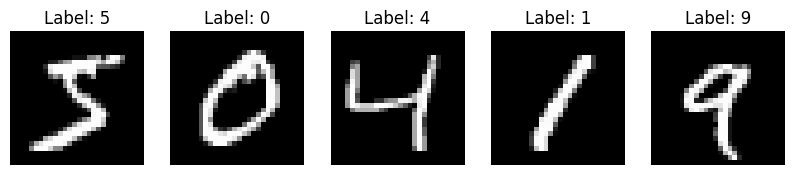

In [3]:
# Display the first 5 images in the dataset and their labels
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')  # Reshape the flat image back to 28x28
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')  # Hide the axis labels

plt.show()

In [4]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Normalize the data using StandardScaler to improve KNN performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [3, 4, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:", grid_search.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperparameters found: {'n_neighbors': 4, 'weights': 'distance'}


In [8]:
# Get the best model based on the grid search
best_knn = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))

Test set accuracy: 94.86%


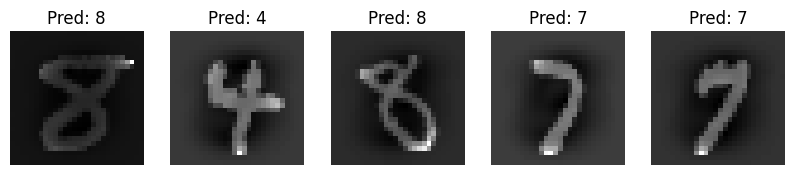

In [9]:
# Display a few images and their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')  # Reshape the flat image back to 28x28
    ax.set_title(f"Pred: {y_pred[i]}")  # Display the predicted label
    ax.axis('off')  # Hide the axis labels

plt.show()

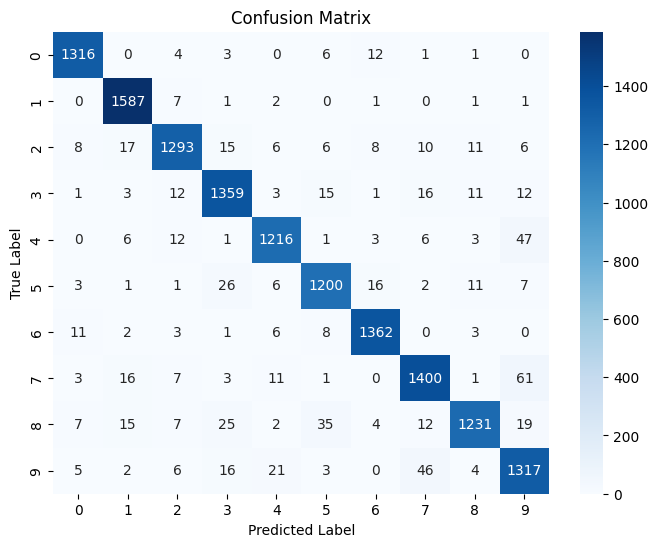

In [10]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

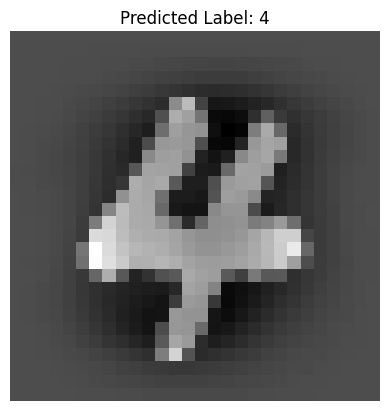

In [11]:
# Classify a random image from the test set (Good practice)
random_index = np.random.randint(0, X_test.shape[0])
random_image = X_test[random_index].reshape(28, 28)

# Display the random image and its prediction
plt.imshow(random_image, cmap='gray')
plt.title(f"Predicted Label: {y_pred[random_index]}")
plt.axis('off')
plt.show()

#### 2.  Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [18]:
def shift_image(image, dx, dy):
    """Shift an MNIST image by dx (horizontal) and dy (vertical)"""
    image = image.reshape(28, 28)
    shifted_image = np.roll(image, shift=dy, axis=0)  # vertical shift
    shifted_image = np.roll(shifted_image, shift=dx, axis=1)  # horizontal shift

    # Zero out wrapped values
    if dy > 0:
        shifted_image[:dy, :] = 0
    elif dy < 0:
        shifted_image[dy:, :] = 0
    if dx > 0:
        shifted_image[:, :dx] = 0
    elif dx < 0:
        shifted_image[:, dx:] = 0

    return shifted_image.flatten()

In [19]:
# Create shifted copies in four directions for data augmentation
X_train_augmented = [X_train]
y_train_augmented = [y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):  # right, left, down, up
    shifted = np.apply_along_axis(shift_image, 1, X_train, dx, dy)
    X_train_augmented.append(shifted)
    y_train_augmented.append(y_train)

# Concatenate all together
X_train_augmented = np.concatenate(X_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)

print("Augmented training shape:", X_train_augmented.shape)

Augmented training shape: (280000, 784)


In [20]:
# Train on augmented dataset
best_knn.fit(X_train_augmented, y_train_augmented)

,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [21]:
# Predict on the TEST SET after training with the augmented dataset
y_pred = best_knn.predict(X_test)


In [22]:
# Measure accuracy using TEST labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with data augmentation using KNN: {accuracy:.4f}")

Test set accuracy with data augmentation using KNN: 0.9588


#### 3. Tackle the Titanic dataset. A great place to start is on Kaggle

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [22]:
# Load Titanic dataset directly from seaborn
titanic = sns.load_dataset('titanic')

# Preview
print(titanic.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [ ]:
# Basic info
print(titanic.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [32]:
print(titanic.describe())

         survived      pclass         sex         age       sibsp       parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413   29.361582    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.019697    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000   28.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             fare    embarked  
count  891.000000  891.000000  
mean    32.204208    0.361392  
std     49.693429    0.635673  
min      0.000000    0.000000  
25%      7.910400    0.000000  
50%     14.454200    0.000000  
75%     31.000000    1.000000  
max    512.329

In [24]:
# Fill missing 'age' values with the median
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# Fill missing 'embarked' values with the mode
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])

In [25]:
# Map 'sex' to 0 (male) and 1 (female)
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# Map 'embarked' to 0 (S), 1 (C), 2 (Q)
titanic['embarked'] = titanic['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [26]:
# Select features to train
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

# Set X and y
X = titanic[features]
y = titanic['survived']

In [27]:
# Check if any NaNs remain before training
print(X.isnull().sum())


pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [28]:
# Split the dataset for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [29]:
# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [ ]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Print the validation accuracy
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Validation Accuracy: 0.7988826815642458


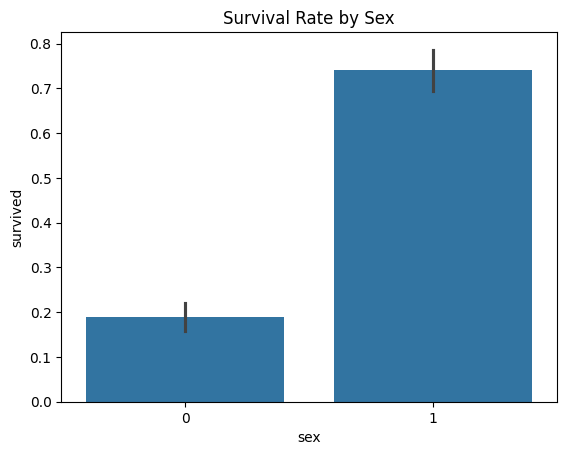

In [31]:
# Plot survival rate by sex for quick insight
sns.barplot(x='sex', y='survived', data=titanic)
plt.title('Survival Rate by Sex')
plt.show()

#### 4. Build a spam classifier (a more challenging exercise):
#### • Download examples of spam and ham from Apache SpamAssassin’s public datasets.
#### • Unzip the datasets and familiarize yourself with the data format.
#### • Split the datasets into a training set and a test set.
#### • Write a data preparation pipeline to convert each email into a feature vector.
#### Your preparation pipeline should transform an email into a (sparse) vector indicating the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
#### • You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).
#### • Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision